In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import phate
import math
import random
import gc
import scprep
from datetime import datetime, time
from matplotlib.animation import ImageMagickWriter
import matplotlib.animation as animation
import zipfile
from urllib.request import urlopen
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import kde
from scipy.stats import binned_statistic
from scipy.stats import f_oneway
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['pdf.fonttype'] = 42
print(sns.__version__)
from anndata import AnnData
import scanpy as sc
from delve import *
import anndata as ad
from sklearn.preprocessing import MinMaxScaler
from kh import sketch
from sklearn.cluster import KMeans
import umap
print(sc.__version__)
today = datetime.now().strftime("%m%d%Y-%H%M")

0.11.2
1.9.1


In [2]:
#Read back in the subsampled adata file
adata_save_path = r'Z:\Garrett\4i_data\112723_RPE_31day_Etop\experiment\cell_data\standard_trimmed_noPSTAT5_adata_sub.h5ad'
standard_trimmed_noPSTAT5_adata_sub = anndata.read_h5ad(adata_save_path)

c:\Users\gases\.conda\envs\python_3_7\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
# Adjusted list comprehension to exclude var_names containing "total"
columns_to_keep = [name for name in standard_trimmed_noPSTAT5_adata_sub.var_names if "total_nuc_protein" not in name]

# Selecting the data with only the columns to keep
standard_trimmed_noPSTAT5_noTotal_adata_sub = standard_trimmed_noPSTAT5_adata_sub[:, columns_to_keep]


In [4]:
def laplacian_score_fs(adata = None,
                    k: int  = None,
                    n_jobs: int  = -1):

    X, feature_names, obs_names = parse_input(adata)
    W = construct_affinity(X = X, k = k, n_jobs = n_jobs)
    scores = laplacian_score(X = X, W = W)
    predicted_features = pd.DataFrame(scores, index = feature_names, columns = ['laplacian_score'])
    predicted_features = predicted_features.sort_values(by = 'laplacian_score', ascending = True)

    return predicted_features 

In [14]:
#l_score_fullest = laplacian_score_fs(adata_fullest_sub, k = 200)
l_score_standard = laplacian_score_fs(standard_trimmed_noPSTAT5_adata_sub, k = 100)
#l_score_normalized = laplacian_score_fs(normalized_trimmed_noPSTAT5_adata_sub, k = 200)

In [15]:
len(l_score_standard)

84

In [7]:
l_score_standard.index[:46]

Index(['R5_p38_nuc_mean', 'R0_pRb_nuc_mean', 'R6_pSTAT3_ring_mean',
       'R2_IL6_ring_mean', 'R0_pRb_ratio', 'R6_p65_ring_mean',
       'R6_pSTAT3_nuc_mean', 'R5_p38_ring_mean', 'R6_p65_nuc_mean',
       'R4_IL8_ring_mean', 'R0_Rb_ratio', 'R1_p21_nuc_mean', 'R2_IL6_nuc_mean',
       'R7_GATA4_nuc_mean', 'R1_p21_ratio', 'R0_Rb_nuc_mean',
       'R7_GATA4_ring_mean', 'nuc_area', 'R5_p38_ratio', 'R7_pp38_nuc_mean',
       'R2_pp65_ring_mean', 'R1_p16_nuc_mean', 'R3_p53_ring_mean',
       'R2_pp65_nuc_mean', 'R3_PLAUR_ring_mean', 'R3_PLAUR_nuc_mean',
       'R1_Jak2_nuc_mean', 'R7_pp38_ring_mean', 'R5_STAT5_ratio',
       'R5_STAT5_nuc_mean', 'R6_p65_ratio', 'R7_pp38_ratio',
       'R1_p21_ring_mean', 'R1_p16_ring_mean', 'R4_PARP1_nuc_mean',
       'R6_pSTAT3_ratio', 'minor_axis_length', 'R5_STAT5_ring_mean',
       'R3_p53_nuc_mean', 'R1_Jak2_ratio', 'R2_IL6_ratio', 'R1_Jak2_ring_mean',
       'R2_pp65_ratio', 'R4_PARP1_ratio', 'R7_GATA4_ratio',
       'major_axis_length'],
      dtype=

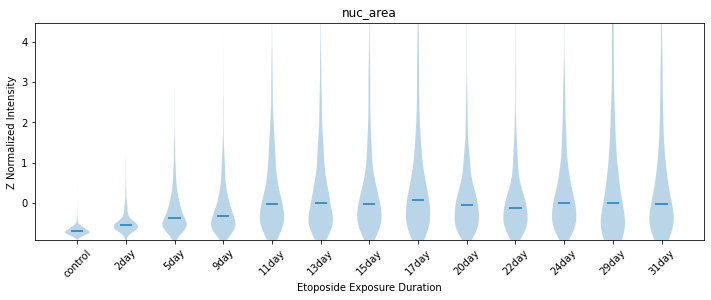

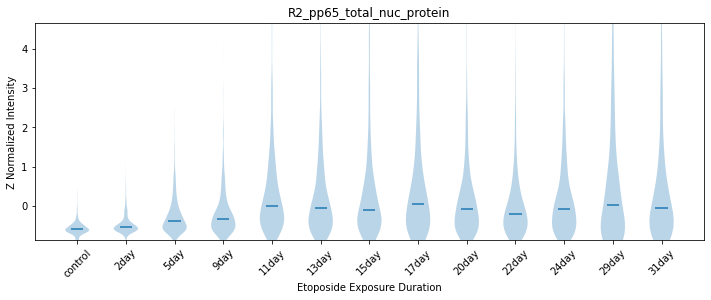

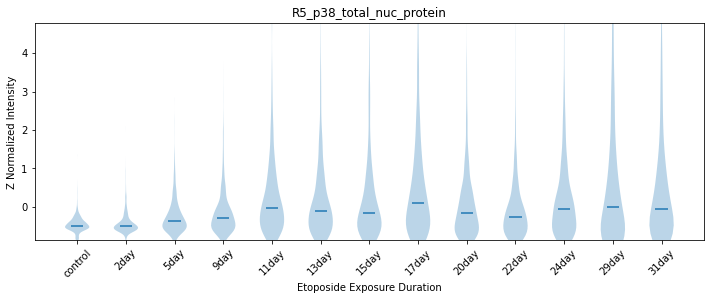

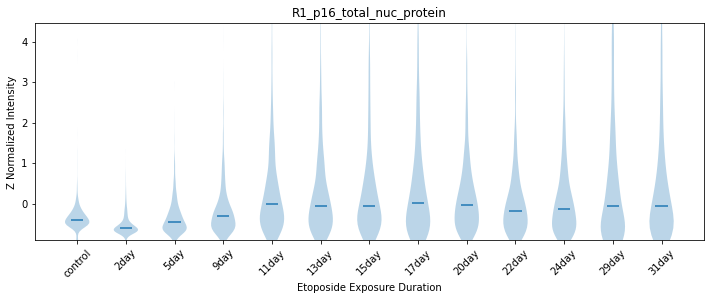

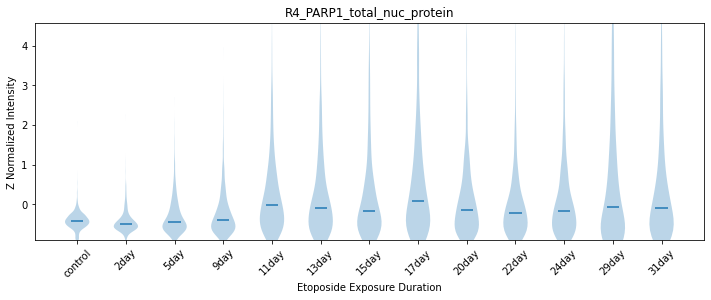

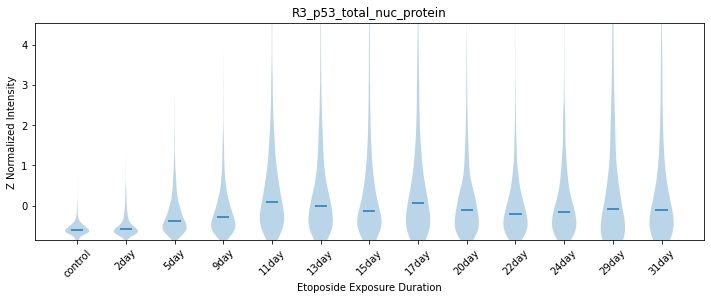

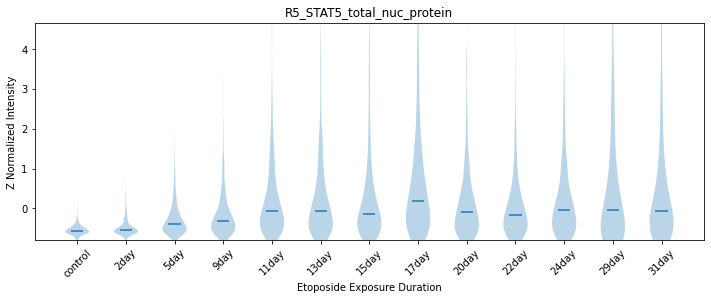

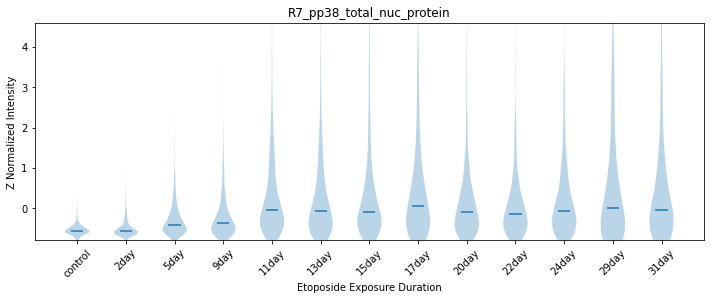

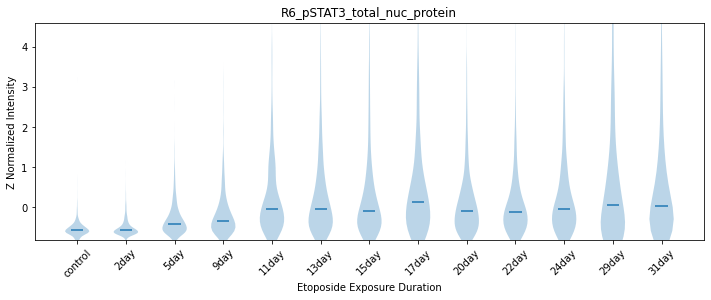

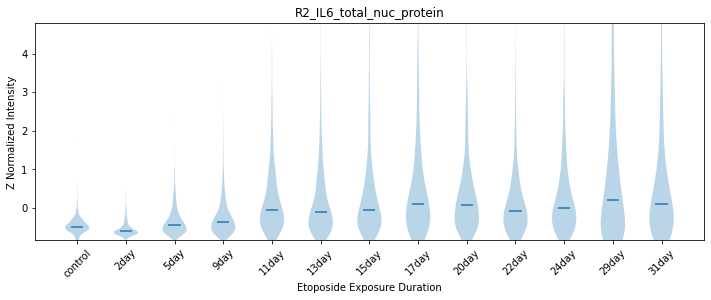

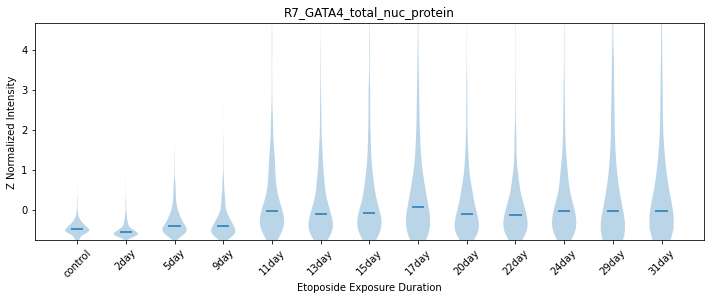

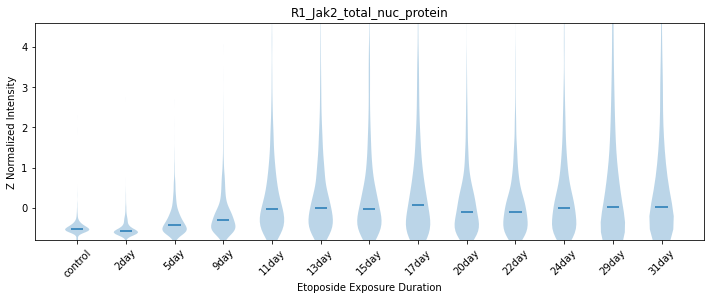

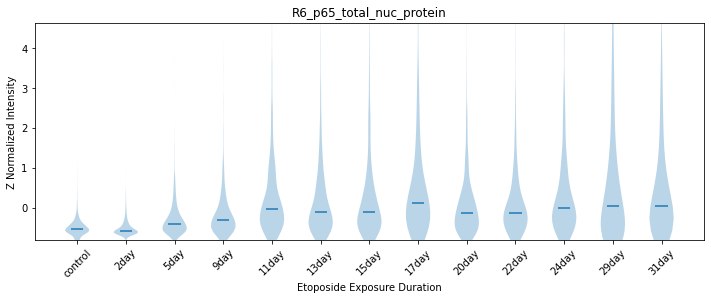

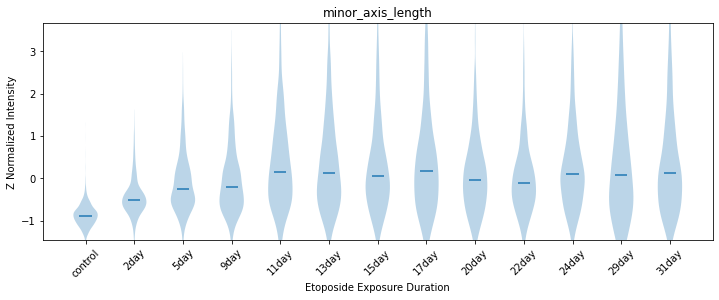

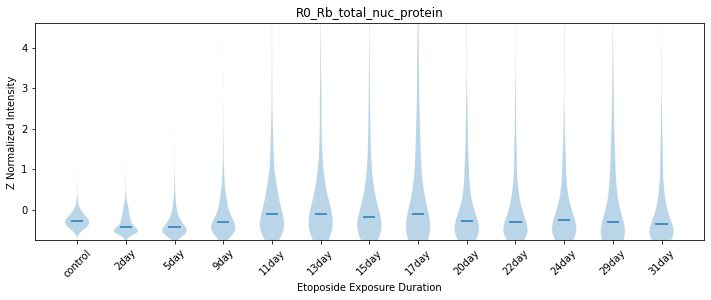

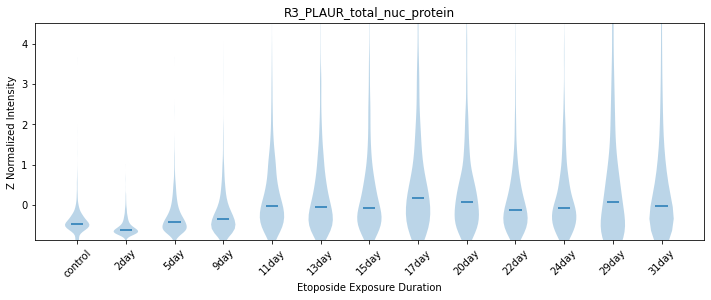

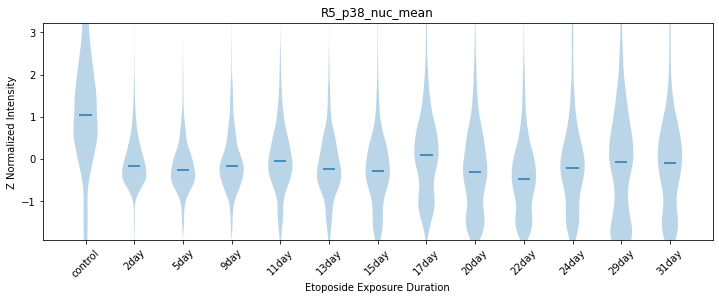

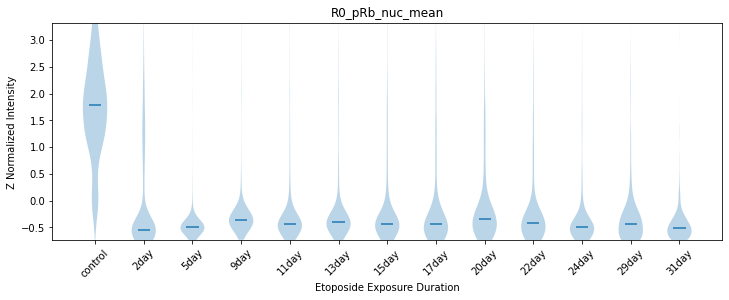

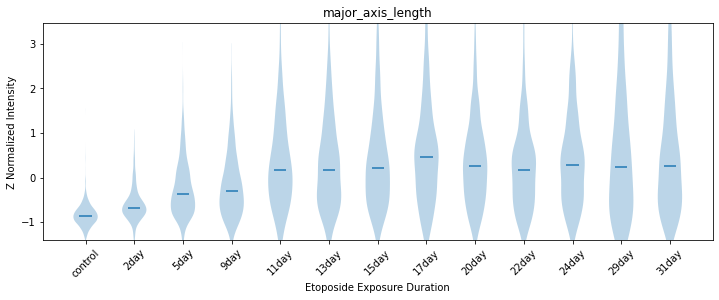

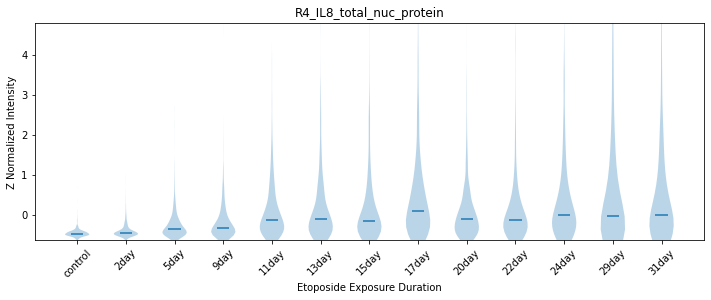

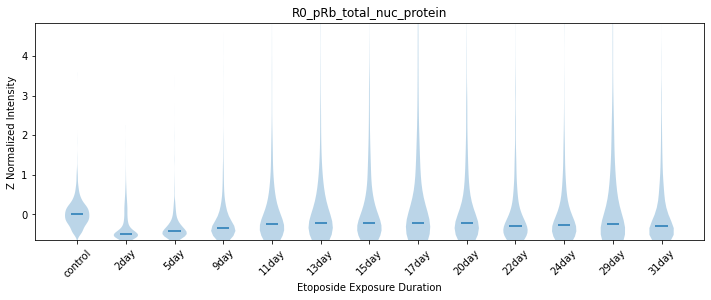

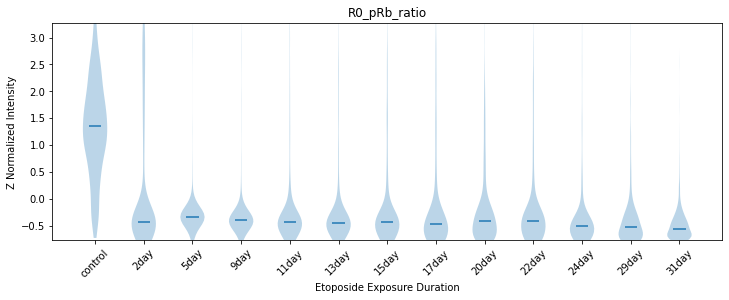

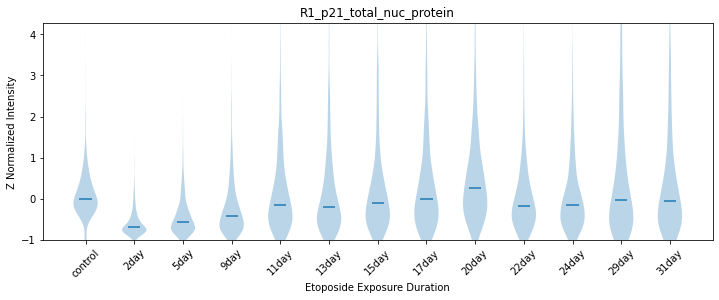

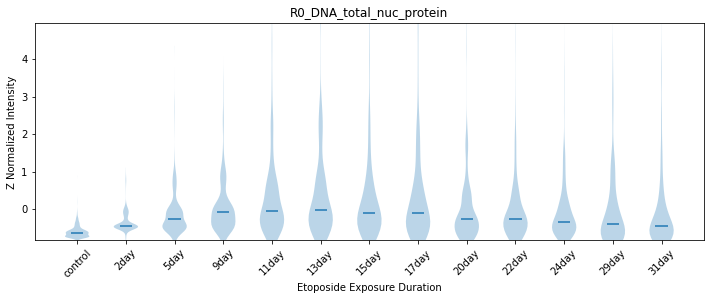

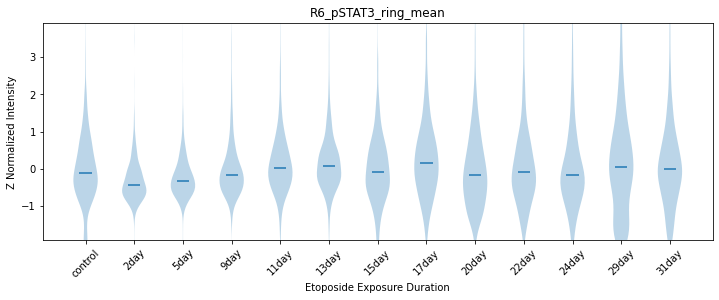

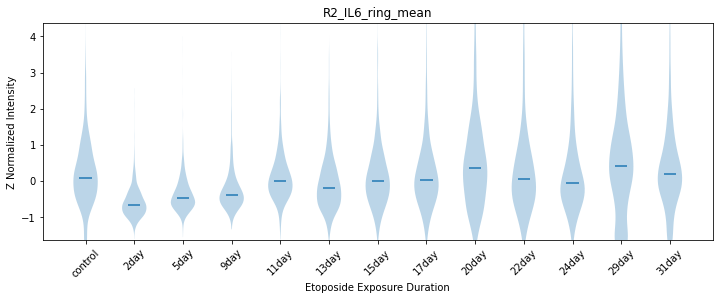

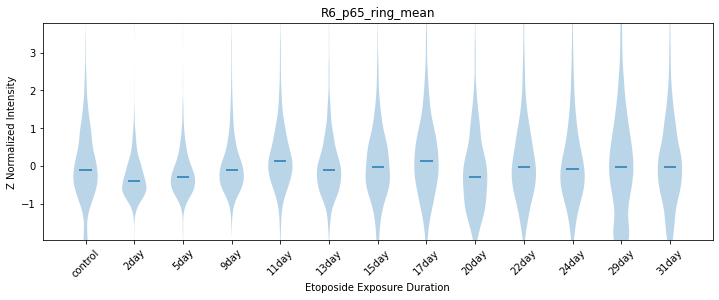

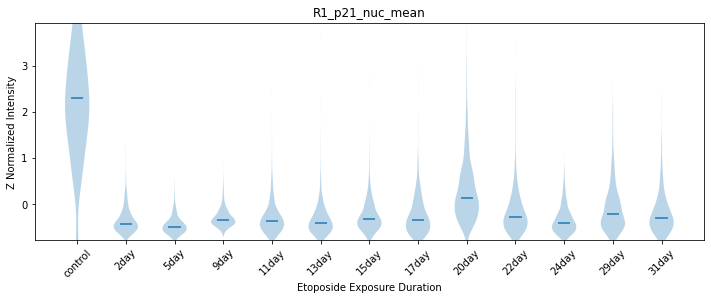

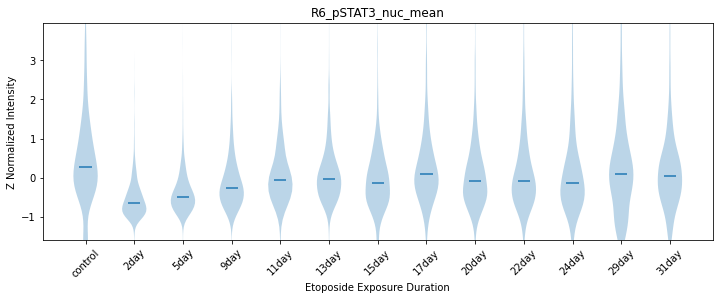

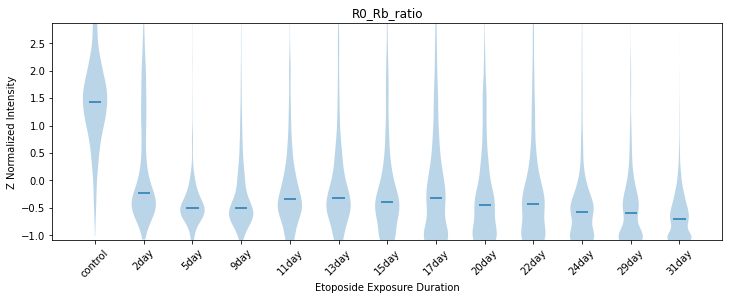

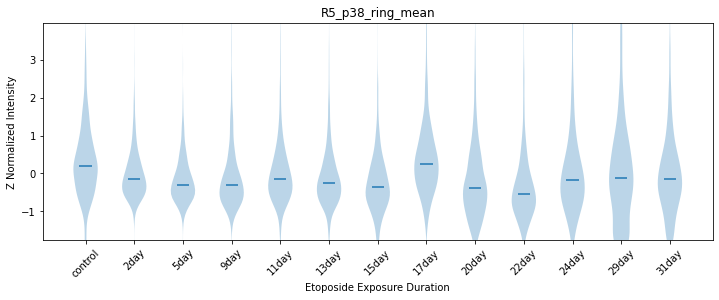

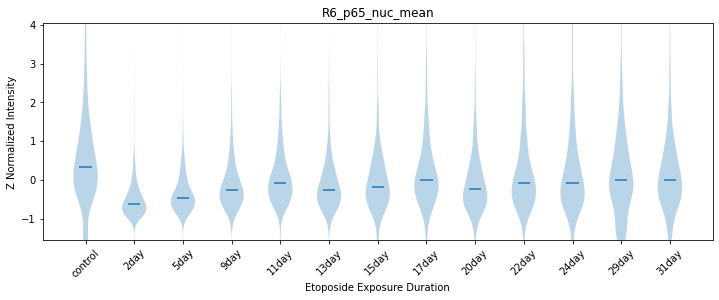

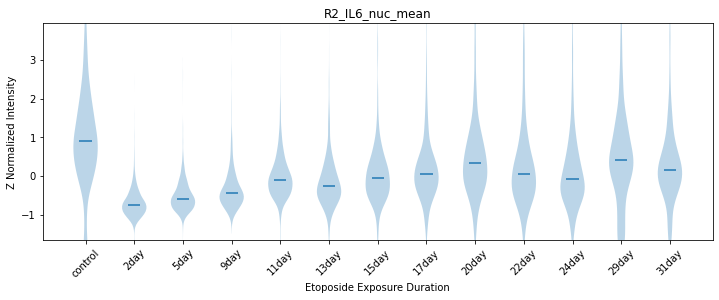

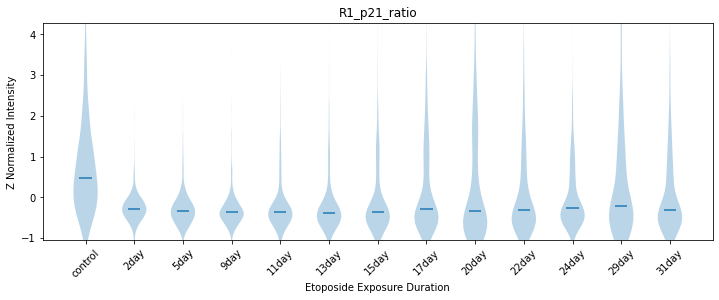

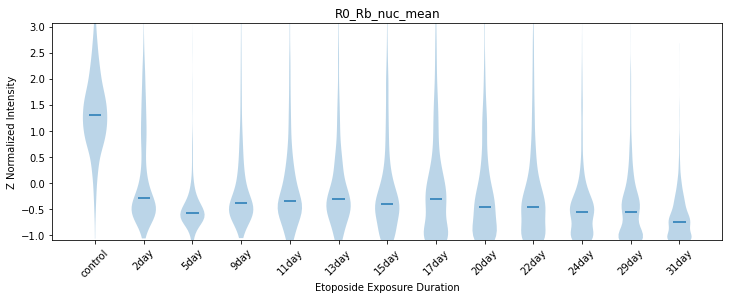

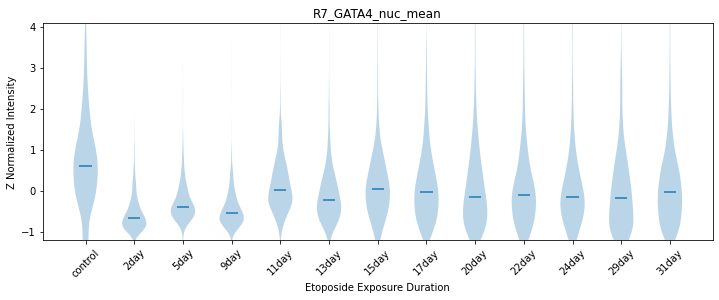

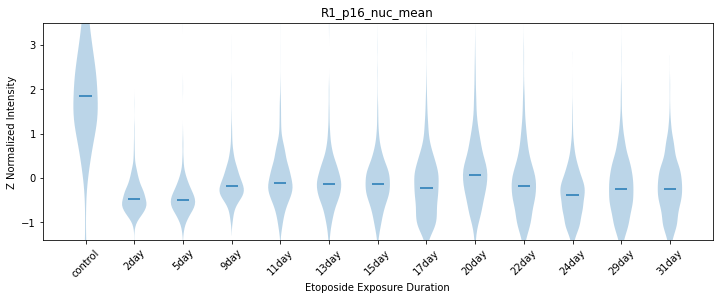

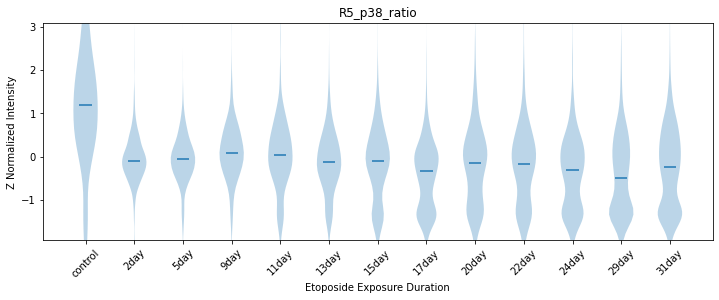

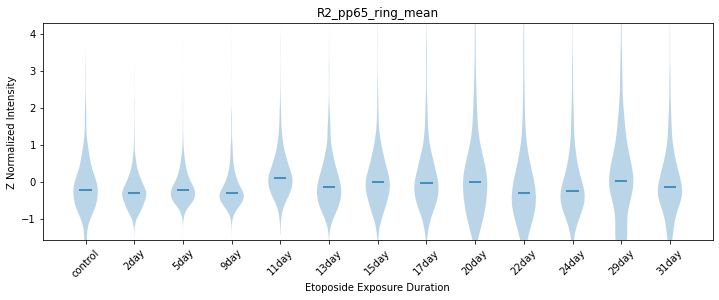

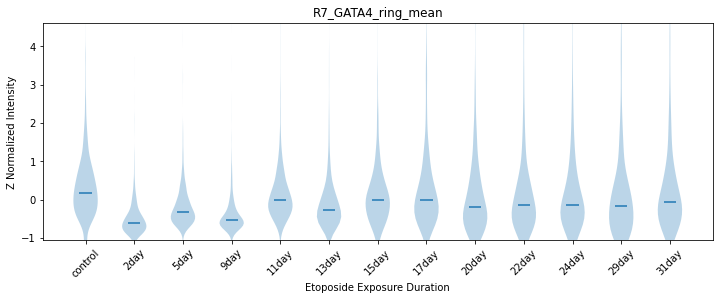

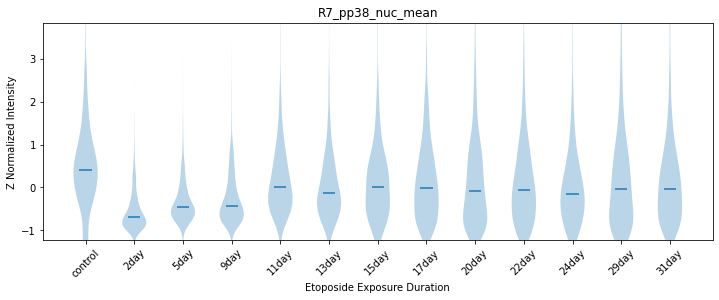

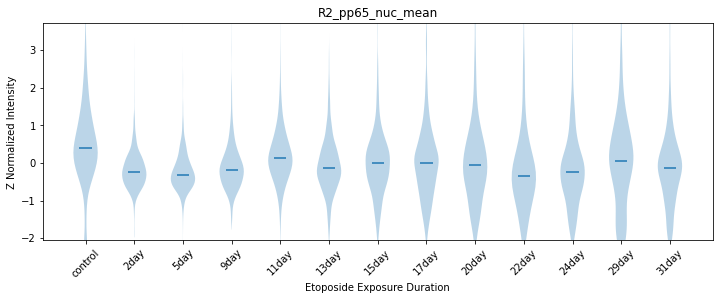

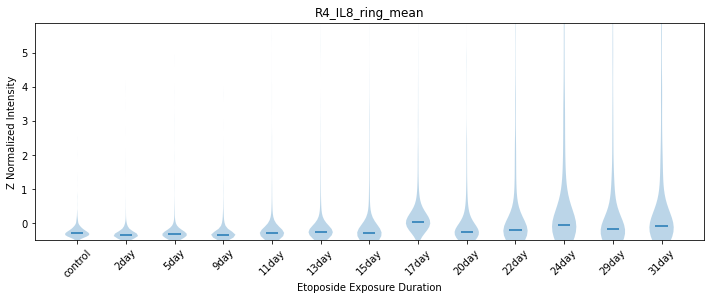

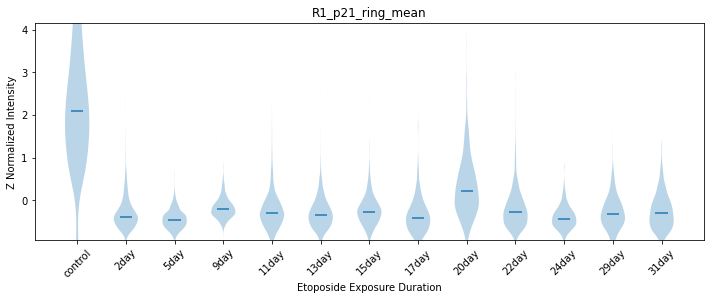

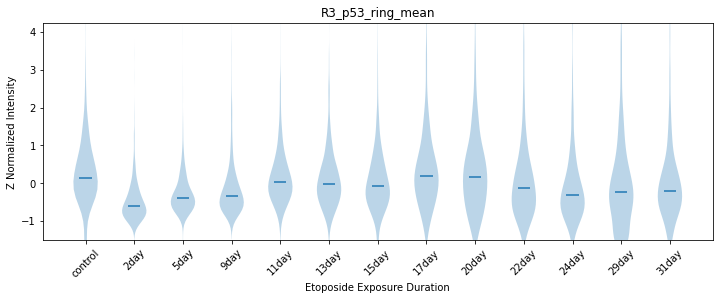

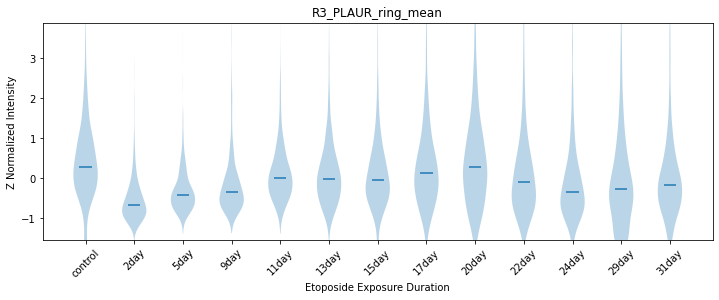

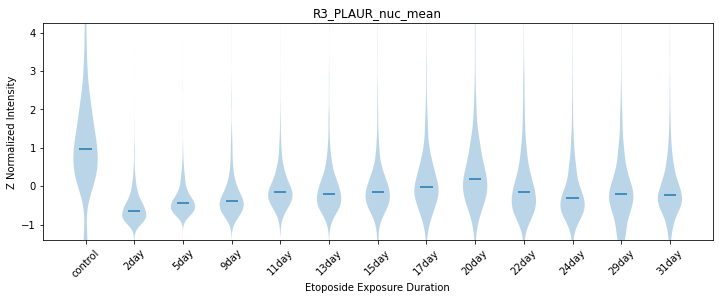

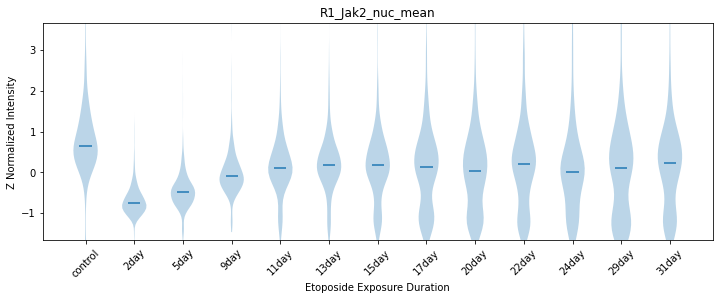

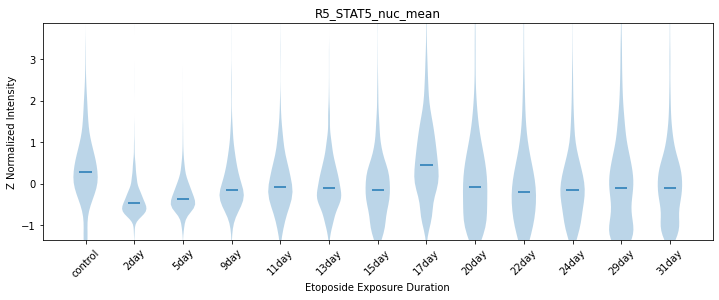

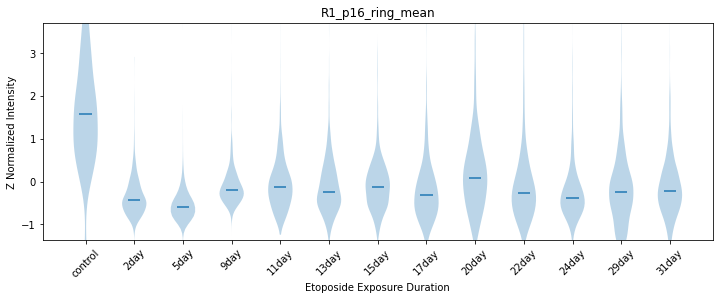

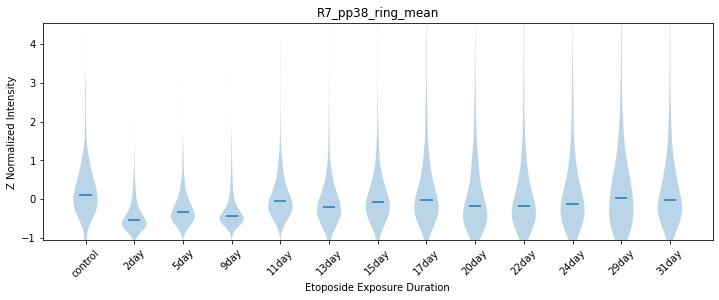

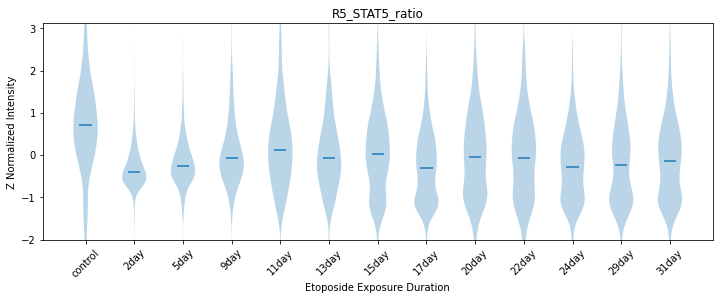

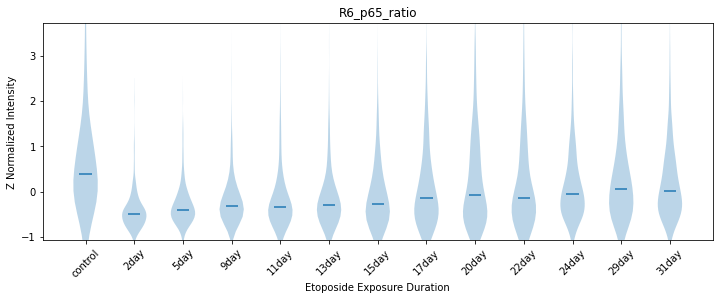

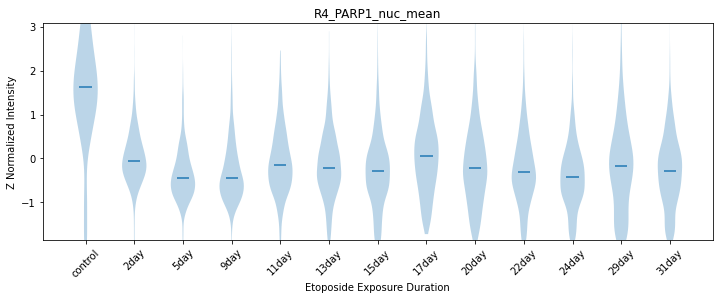

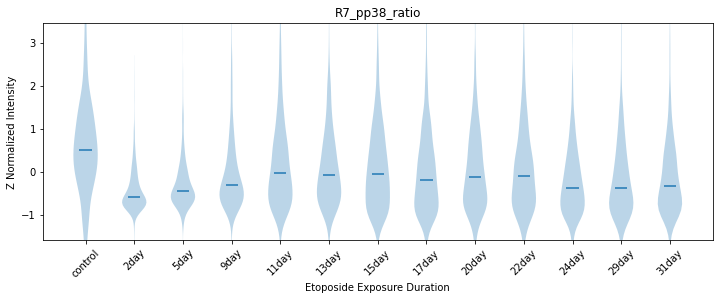

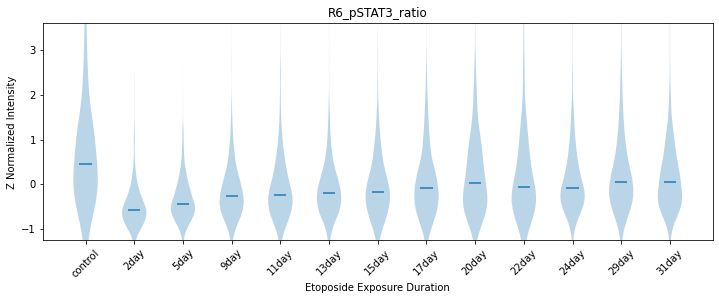

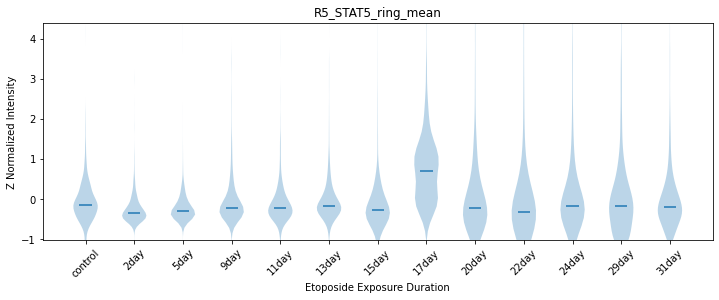

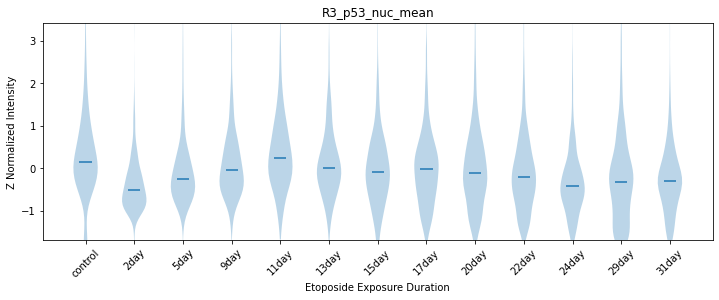

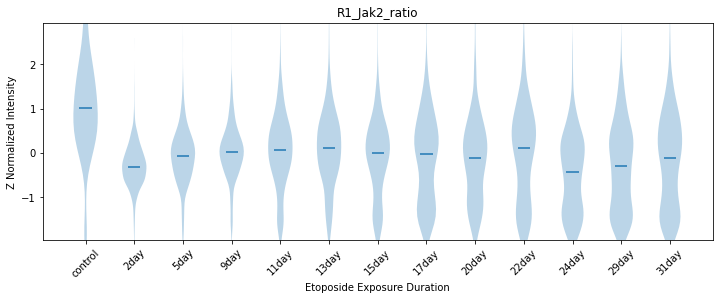

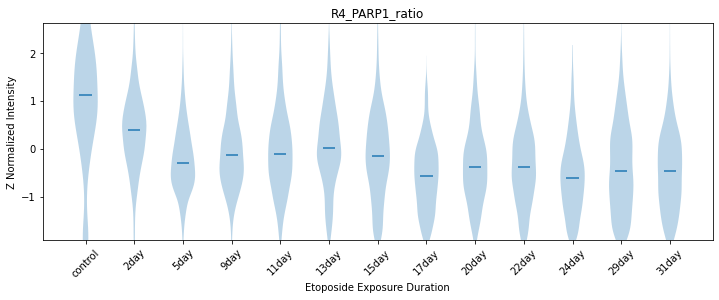

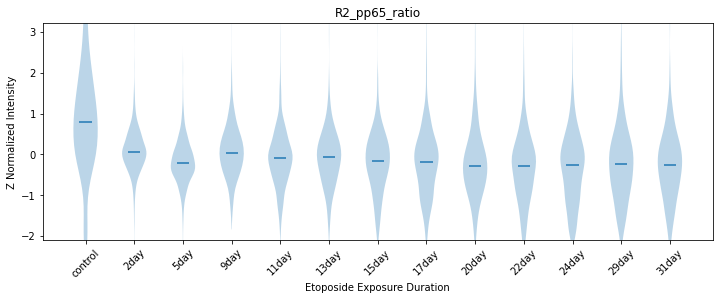

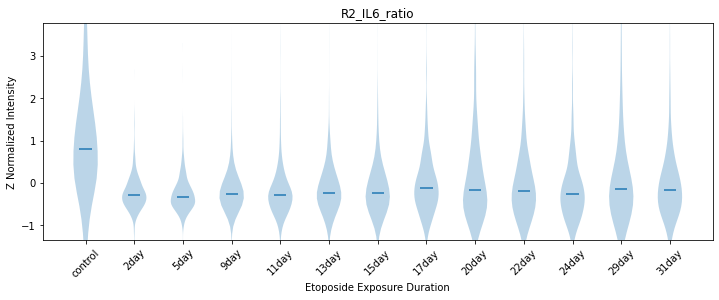

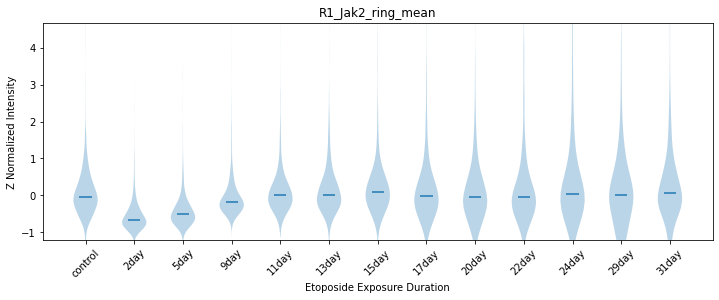

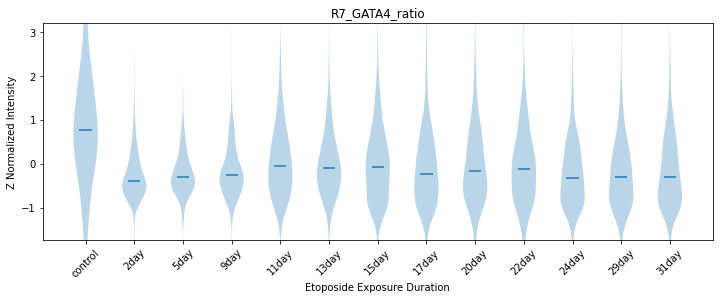

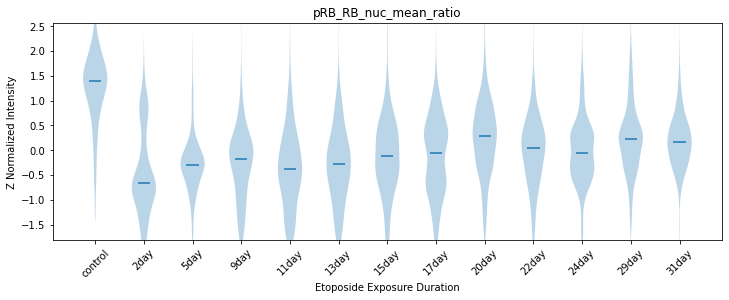

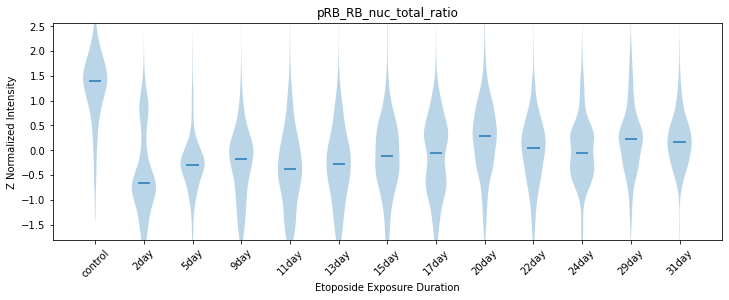

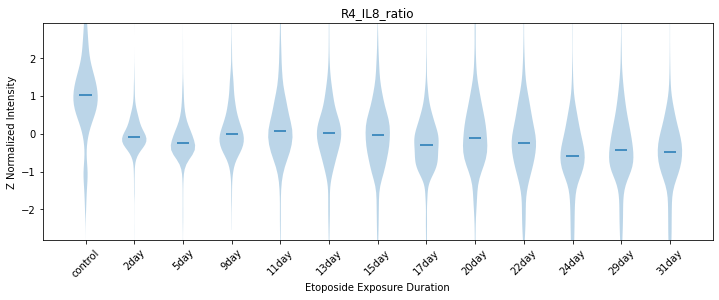

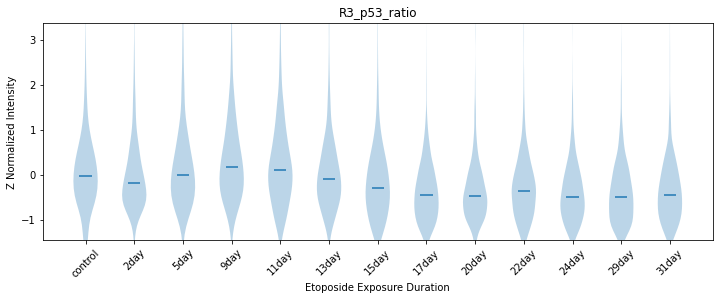

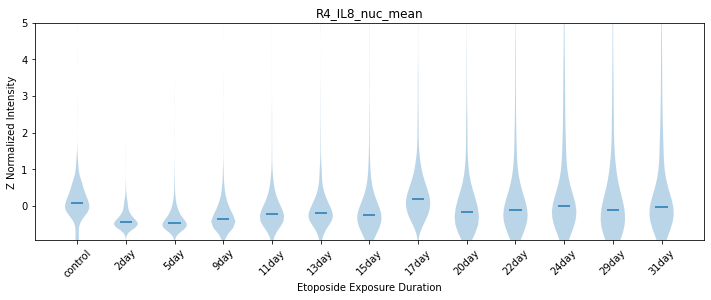

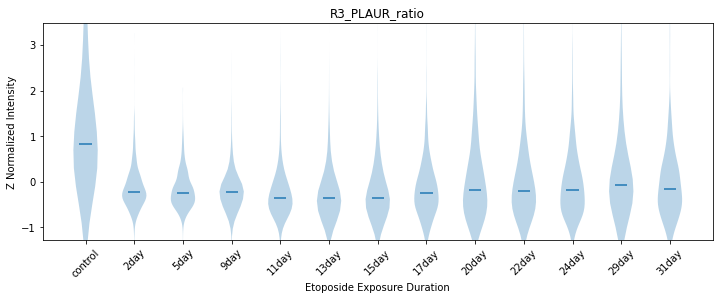

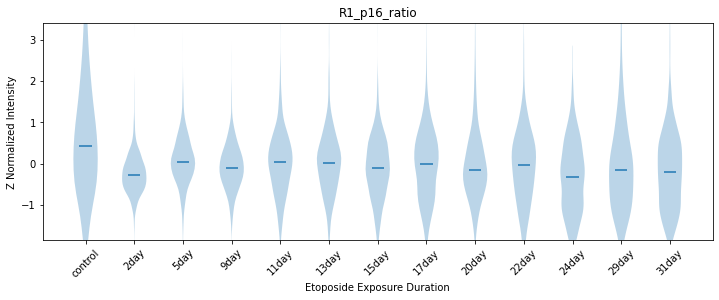

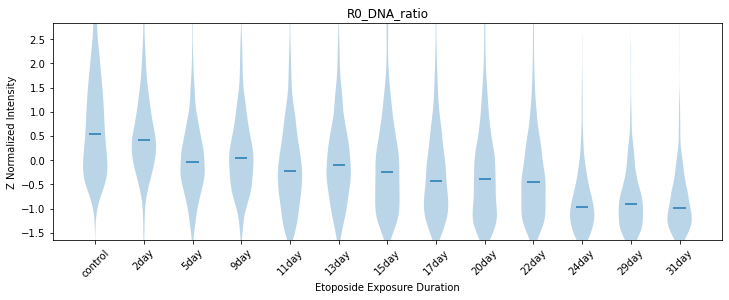

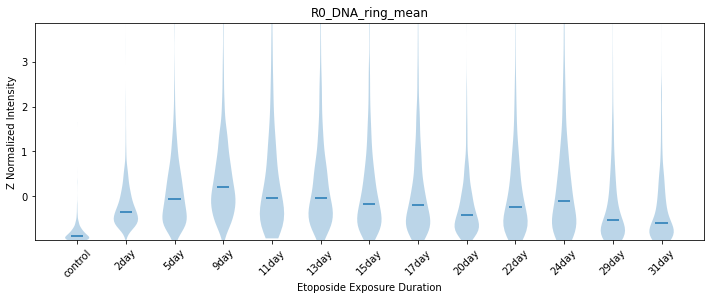

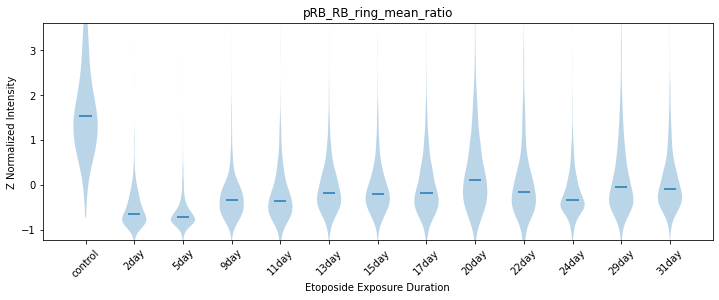

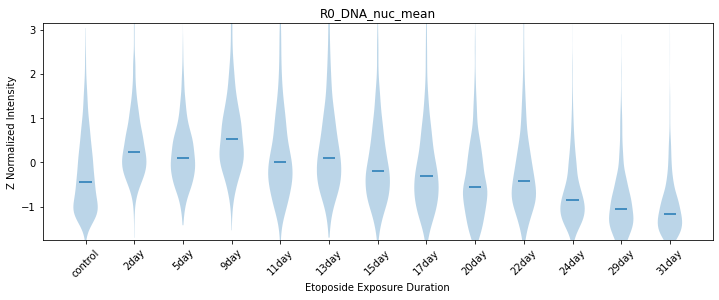

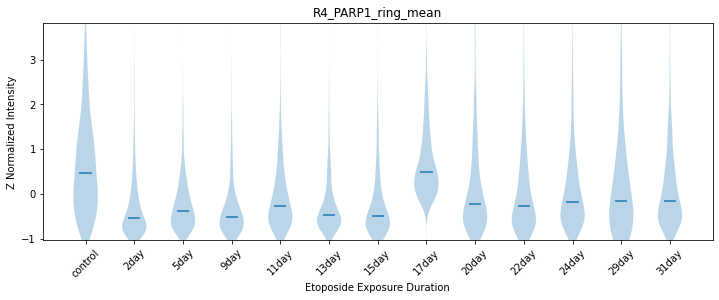

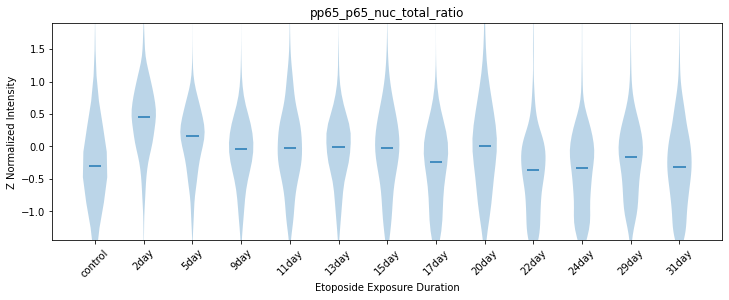

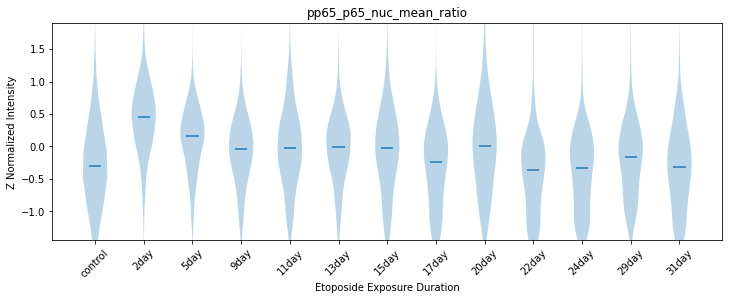

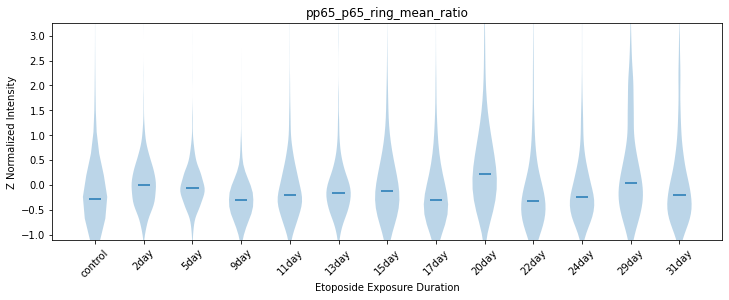

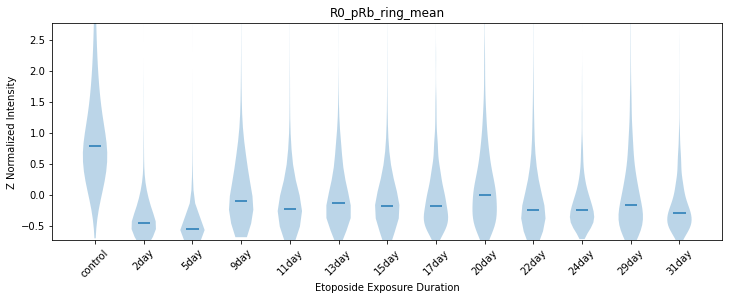

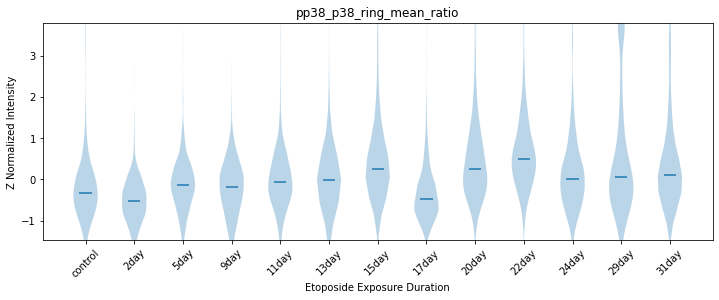

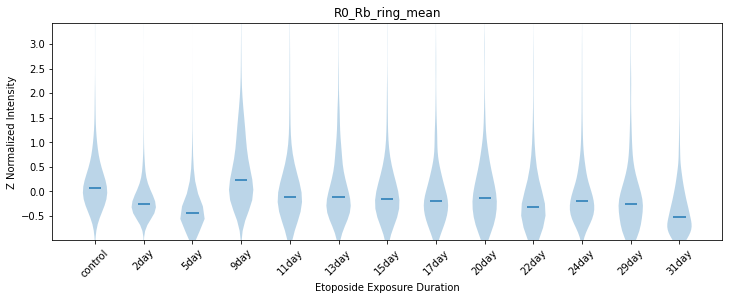

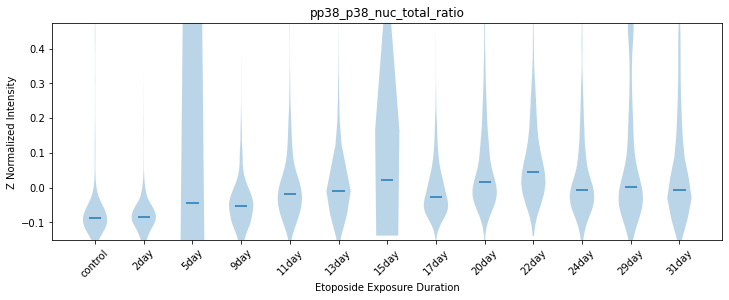

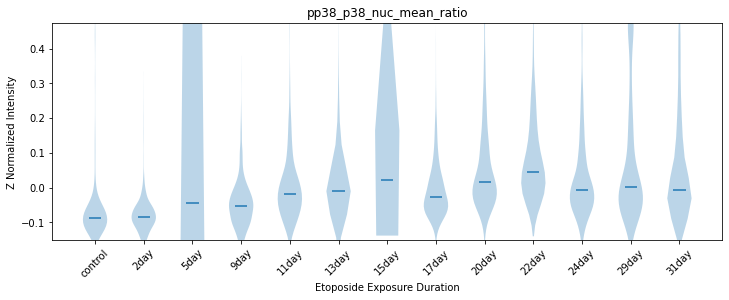

In [16]:
# Extract relevant columns from adata_sub.obs
sample_ids = standard_trimmed_noPSTAT5_adata_sub.obs['sample_ID']
treatment = standard_trimmed_noPSTAT5_adata_sub.obs['treatment']

protein_list = (l_score_standard.index[:84])
for protein_name in protein_list:

    # Get the index of the protein in adata_sub.X
    protein_index = np.where(standard_trimmed_noPSTAT5_adata_sub.var_names == protein_name)[0][0]

    # Specify the sample IDs you want to include
    selected_sample_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14]

    # Initialize the data arrays for violin plots and corresponding treatments
    data = []
    treatments = []

    # Generate data and corresponding treatments for each sample ID
    for sample_id in selected_sample_ids:
        # Filter data for the current sample ID
        sample_data = standard_trimmed_noPSTAT5_adata_sub.X[sample_ids == sample_id, protein_index]

        # Filter treatment for the current sample ID
        sample_treatment = treatment[sample_ids == sample_id][0]

        # Check if sample_data is empty
        if len(sample_data) > 0:
            # Store the sample data and treatment
            data.append(sample_data)
            treatments.append(sample_treatment)

    # Create violin plots if there is data available
    if data:
        plt.figure(figsize=(12, 4))  # Set the size of the plot
        plt.violinplot(data, showmeans=False, showmedians=True, showextrema=False)  # Remove vertical lines

        # Add labels and legend
        plt.xlabel('Etoposide Exposure Duration')
        plt.ylabel('Z Normalized Intensity')
        plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
        plt.xticks(np.arange(1, len(selected_sample_ids) + 1), treatments)
        plt.title(protein_name)

        # Set custom y-axis limits
        plt.ylim(bottom=np.percentile(np.concatenate(data), 1), top=np.percentile(np.concatenate(data), 99))  # Adjust the percentile as needed

        # Show the plot
        plt.show()
